In [2]:
import pandas as pd
import os
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import OrderedDict
from torchvision import models
import torch.nn.functional as F 
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
from typing_extensions import dataclass_transform
import random

torch.manual_seed(42)
np.random.seed(42)

In [6]:
class SkinData:
  def __init__(self, root, transform = True, train = True):
      if train:
        data_folder = 'balanced_dataset/'

      else:
        data_folder = 'Validation_Image/'

      data_dirs = os.listdir(os.path.join(root,data_folder))
      self.data_files = []
      self.labels = []
      label = 0
      for dir in data_dirs:
        path_name = os.path.join(root,data_folder,dir)
        data_samples = [os.path.join(path_name, fname) for fname in os.listdir(path_name)]
        label_samples = label * np.ones(len(data_samples))
        print(dir)
        print(len(label_samples))
        self.data_files.extend(data_samples)
        self.labels.extend(label_samples)
        self.transform = transform

        label += 1

  def __len__(self):
    return len(self.data_files)

  def __getitem__(self, index):
    new_width = 256
    new_height = 256
    data_file = self.data_files[index]
    image = np.array(cv2.imread(data_file))
    label = np.array(self.labels[index])

    data_sample = cv2.resize(image, (new_width, new_height))
    resize_data = np.array(data_sample)

    if self.transform:
      data_sample = torch.from_numpy(data_sample)
      lable = torch.from_numpy(label)

    data_point = {'data_sample': data_sample, 'lable':lable}

    return data_point

In [7]:
root = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer'
dataset = SkinData(root, transform=True, train= True)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# train_loder = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_loder = DataLoader(test_dataset, batch_size=8, shuffle=False)

test_dataset = SkinData(root, transform=True, train = False)

dataloader_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=8, shuffle=False)
dataloader_val = DataLoader(val_dataset, batch_size=8, shuffle=False)

akiec
1244
bcc
1464
bkl
1044
df
1308
mel
1057
nv
1302
vasc
1350
akiec
16
bcc
26
bkl
55
df
6
mel
56
nv
335
vasc
7


In [200]:
len(train_dataset)

7015

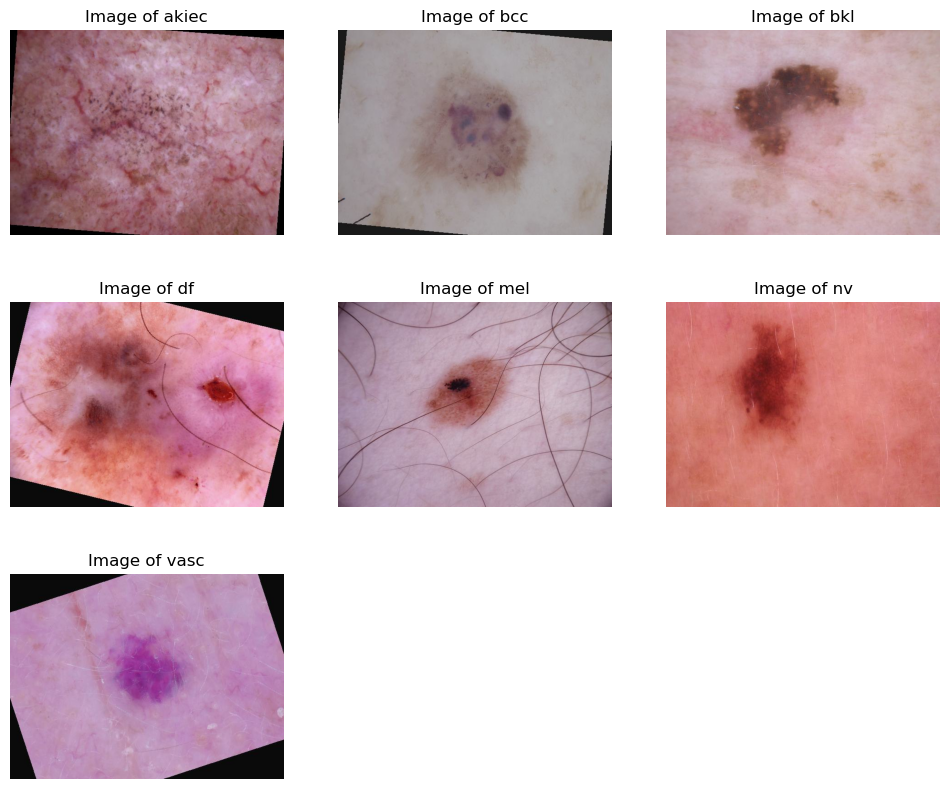

In [8]:
# Data Visualization
# Define the directory path for the training images
train_images_dir = r"C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Balanced_dataset"

top_n = 20  # Variable for top-n random images to select from.
image_sample = []  # List containing array of images.
image_sample_category = []  # List containing image type

# Make sure train_images_dir is correctly defined before this loop
for sub_dir in os.scandir(train_images_dir):
    images_paths = [image.path for image in os.scandir(sub_dir)]
    current_dir_img_paths = []  # List of top n images from current sub-dir.

    # Ensure we handle cases where there are fewer than top_n images
    num_images = min(len(images_paths), top_n)

    # Appending up to top_n images from the current sub-dir
    for image_path in images_paths[:num_images]:
        current_dir_img_paths.append(image_path)

    # Select a random image from the current directory
    if current_dir_img_paths:
        selected_image = random.choice(current_dir_img_paths)  # Selecting random image from the list
        image = cv2.imread(selected_image)  # Reading the image

        if image is not None:
            image = image[:, :, ::-1]  # Converting BGR to RGB
            image_sample_category.append(sub_dir.name)  # Append image category (cancer type)
            image_sample.append(image)  # Append the image array to the list
        else:
            print(f"Warning: Could not read image {selected_image}")
    else:
        print(f"No images found in directory {sub_dir.name}")

# Plotting the selected random images
plt.figure(figsize=(12, 10))
for num in range(len(image_sample)):
    plt.subplot(3, 3, num + 1)
    plt.axis(False)
    plt.title(f"Image of {image_sample_category[num]}")
    plt.imshow(image_sample[num])

plt.show()

tensor(0., dtype=torch.float64)


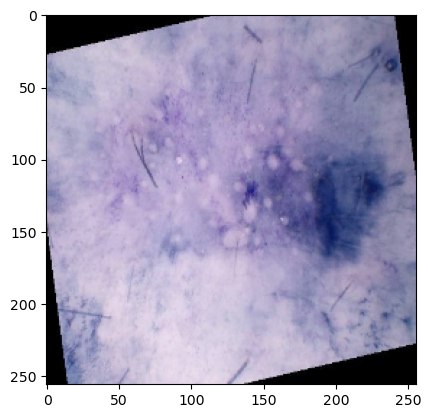

In [9]:
plt.imshow(train_dataset[1000]['data_sample'])
print(train_dataset[1000]['lable'])

In [10]:
train_dataset[1000]['data_sample'].shape

torch.Size([256, 256, 3])

In [204]:
# # Train Accuracy: 73.26%, Validation Accuracy: 64.56%
# import torch
# import torch.nn as nn

# class ImprovedCNNNet(nn.Module):
#     def __init__(self):
#         super(ImprovedCNNNet, self).__init__()
#         self.main = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 256 x 256 x 32
#             nn.BatchNorm2d(32),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 128 x 128 x 32
            
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 128 x 128 x 64
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 64 x 64 x 64

#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 64 x 64 x 128
#             nn.BatchNorm2d(128),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 32 x 32 x 128

#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 32 x 32 x 256
#             nn.BatchNorm2d(256),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 16 x 16 x 256

#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 16 x 16 x 512
#             nn.BatchNorm2d(512),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 8 x 8 x 512
            
#             nn.Flatten(),  # Flatten the 8x8x512 to a vector
#             nn.Linear(8 * 8 * 512, 1024, bias=True),
#             nn.ReLU(True),
#             nn.Dropout(0.5),  # Dropout to reduce overfitting
#             nn.Linear(1024, 512, bias=True),
#             nn.ReLU(True),
#             nn.Dropout(0.5),
#             nn.Linear(512, 128, bias=True),
#             nn.ReLU(True),
#             nn.Linear(128, 7, bias=True),  # Output layer for 7 classes
#             nn.LogSoftmax(dim=1)
#         )
    
#     def forward(self, x):
#         out = self.main(x)
#         return out

In [205]:
# class ImprovedCNNNet(nn.Module):
#     def __init__(self):
#         super(ImprovedCNNNet, self).__init__()
#         self.main = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 256 x 256 x 32
#             nn.BatchNorm2d(32),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 128 x 128 x 32

#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(1,1), padding=2, bias=True),  # 128 x 128 x 64
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 64 x 64 x 64

#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 64 x 64 x 128
#             nn.BatchNorm2d(128),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 32 x 32 x 128

#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 32 x 32 x 256
#             nn.BatchNorm2d(256),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 16 x 16 x 256

#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=1, bias=True),  # 16 x 16 x 512
#             nn.BatchNorm2d(512),
#             nn.ReLU(True),
#             nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # 8 x 8 x 512

#             nn.Flatten(),  # Flatten the 8x8x512 to a vector
#             nn.Linear(8 * 8 * 512, 1024, bias=True),
#             nn.ReLU(True),
#             nn.Dropout(0.5),  # Dropout to reduce overfitting
#             nn.Linear(1024, 512, bias=True),
#             nn.ReLU(True),
#             nn.Dropout(0.5),
#             nn.Linear(512, 128, bias=True),
#             nn.ReLU(True),
#             nn.Linear(128, 7, bias=True),  # Output layer for 7 classes
#             nn.LogSoftmax(dim=1)
#         )

#     def forward(self, x):
#         out = self.main(x)
#         return out

In [11]:
# Model definition (from previous artifact)
class ResNetSkinCancer(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNetSkinCancer, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        for param in list(self.resnet.parameters())[:-30]:
            param.requires_grad = False
        num_features = self.resnet.fc.in_features
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )
        self.resnet.fc = self.classifier

    def forward(self, x):
        return self.resnet(x)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
net = ResNetSkinCancer().to(device)

c:\Users\vindu\anaconda\envs\my\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vindu\anaconda\envs\my\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
print(torch.cuda.get_device_name(0))  # To check your GPU device name
print(torch.cuda.is_available())  # To confirm GPU is available

NVIDIA GeForce RTX 3050 Laptop GPU
True


In [ ]:
import torch.optim as optim
# Print the network architecture
print(net)
# Optimizer: Adamax
optimizer = optim.Adamax(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# Loss function

# Example: Suppose you have 7 classes with these sample counts
class_counts = torch.tensor([1244, 1464, 1044, 1308, 1057, 1302, 1350], dtype=torch.float32)

# Compute weights (inverse of class frequencies)
class_weights = 1.0 / class_counts  
class_weights /= class_weights.sum()  # Normalize to sum to 1

# Move weights to device (if using GPU)
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

ResNetSkinCancer(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [211]:
len(dataloader_train)

439

In [26]:
# Lists to store average losses and accuracies per epoch
avg_train_loss_list = []
avg_val_loss_list = []
train_acc_list = []
val_acc_list = []

# Define the directory to save/load models
save_dir = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\resnet50'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to load the latest checkpoint
def load_checkpoint(model, optimizer, filename='latest_checkpoint.pth'):
    if os.path.exists(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
        print(f"Resuming from epoch {start_epoch}")
    else:
        print(f"No checkpoint found at '{filename}', starting from scratch")
        start_epoch = 0  # Start from scratch if no checkpoint
    return start_epoch

# Load checkpoint if exists
checkpoint_path = os.path.join(save_dir, 'latest_checkpoint.pth')
start_epoch = load_checkpoint(net, optimizer,filename=checkpoint_path)

# Training Loop
for epoch in range(start_epoch,start_epoch+20):  # Now starts from the saved epoch
    accuracy = 0
    val_accuracy = 0
    running_loss = 0.0
    val_running_loss = 0.0
    num_batches_train = len(dataloader_train)
    num_batches_val = len(dataloader_val)

    # Training loop
    for i, data in enumerate(dataloader_train, 0):
        input = data['data_sample'].float().to(device)
        input = input.permute(0, 3, 1, 2)
        labels = data['lable'].to(device)
        encoded_labels = F.one_hot(labels.long(), num_classes=7)

        prediction = net(input)
        loss = criterion(prediction, encoded_labels.float())
        running_loss += loss.item()

        predicted_class = torch.argmax(prediction, dim=1)
        accuracy += sum(predicted_class == labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print('epoch:', epoch, 'loss:', loss.item())

    avg_train_loss = running_loss / num_batches_train
    avg_train_loss_list.append(avg_train_loss)

    # Validation loop
    for i, data in enumerate(dataloader_val, 0):
        input = data['data_sample'].float().to(device)
        input = input.permute(0, 3, 1, 2)
        labels = data['lable'].to(device)
        encoded_labels = F.one_hot(labels.long(), num_classes=7)

        prediction = net(input)
        val_loss = criterion(prediction, encoded_labels.float())
        val_running_loss += val_loss.item()

        predicted_class = torch.argmax(prediction, dim=1)
        val_accuracy += sum(predicted_class == labels)

    avg_val_loss = val_running_loss / num_batches_val
    avg_val_loss_list.append(avg_val_loss)

    print(f'Epoch {epoch}: Train Accuracy: {accuracy/train_dataset.__len__()*100:.2f}%, '
          f'Validation Accuracy: {val_accuracy/val_dataset.__len__()*100:.2f}%')

    accuracy = accuracy.cpu().numpy()
    train_acc_list.append(accuracy / train_dataset.__len__() * 100)
    val_accuracy = val_accuracy.cpu().numpy()
    val_acc_list.append(val_accuracy / val_dataset.__len__() * 100)

    scheduler.step()

    # Save model checkpoint after each epoch
    torch.save({
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': loss.item(),
}, os.path.join(save_dir, 'latest_checkpoint.pth'), _use_new_zipfile_serialization=False)


    print(f'Model saved after epoch {epoch}')
    print(f'Average Train Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}')

    # After each epoch, save metrics to a CSV file
    metrics_df = pd.DataFrame({
        'Epoch': [epoch],
        'Train Accuracy': [train_acc_list[-1]],
        'Validation Accuracy': [val_acc_list[-1]],
        'Average Train Loss': [avg_train_loss],
        'Average Validation Loss': [avg_val_loss]
    })

    metrics_df.to_csv(os.path.join(save_dir, 'training_metrics.csv'), mode='a', index=False, header=not os.path.exists(os.path.join(save_dir, 'training_metrics.csv')))
    print("Epoch metrics saved to training_metrics.csv")



Loading checkpoint 'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\resnet50\latest_checkpoint.pth'


C:\Users\vindu\AppData\Local\Temp\ipykernel_18864\2150158589.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Resuming from epoch 52
epoch: 52 loss: 0.016513988375663757
epoch: 52 loss: 0.029725391417741776
epoch: 52 loss: 0.042906053364276886
epoch: 52 loss: 0.014951927587389946
epoch: 52 loss: 0.04959436506032944
epoch: 52 loss: 0.049250535666942596
epoch: 52 loss: 0.04765266925096512
epoch: 52 loss: 0.011791958473622799
epoch: 52 loss: 0.0325189083814621
Epoch 52: Train Accuracy: 93.70%, Validation Accuracy: 72.98%
Model saved after epoch 52
Average Train Loss: 0.0361, Average Validation Loss: 0.1182
Epoch metrics saved to training_metrics.csv
epoch: 53 loss: 0.02379164844751358
epoch: 53 loss: 0.03298604115843773
epoch: 53 loss: 0.024643853306770325
epoch: 53 loss: 0.00900973379611969
epoch: 53 loss: 0.025482887402176857
epoch: 53 loss: 0.040648043155670166
epoch: 53 loss: 0.012088167481124401
epoch: 53 loss: 0.05973013490438461
epoch: 53 loss: 0.05096396803855896
Epoch 53: Train Accuracy: 94.10%, Validation Accuracy: 73.20%
Model saved after epoch 53
Average Train Loss: 0.0350, Average Va

KeyboardInterrupt: 

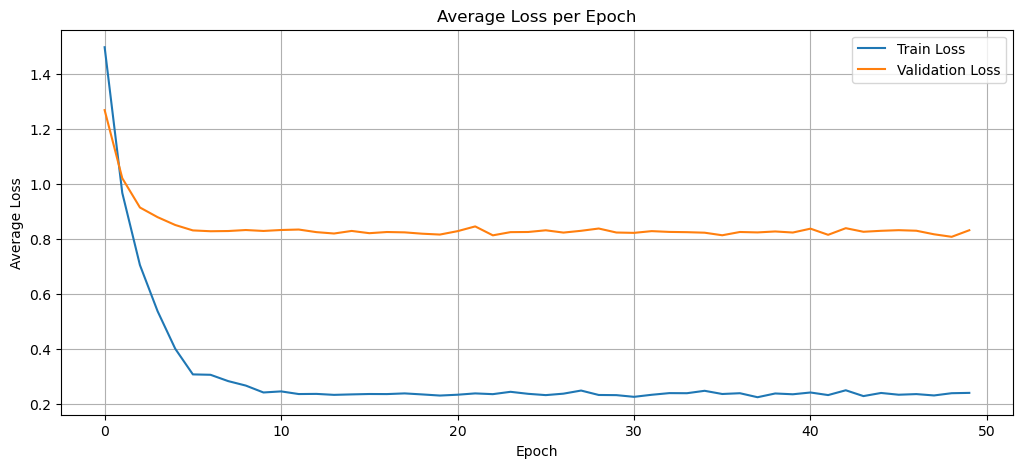

In [12]:
# Path to the CSV file
csv_file_path = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\resnet50\training_metrics.csv'

# Load the metrics from the CSV file
metrics_df = pd.read_csv(csv_file_path)

# Plot Average Losses
plt.figure(figsize=(27, 5))

plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(metrics_df['Epoch'], metrics_df['Average Train Loss'], label='Train Loss')
plt.plot(metrics_df['Epoch'], metrics_df['Average Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Loss per Epoch')
plt.legend()
plt.grid(True)

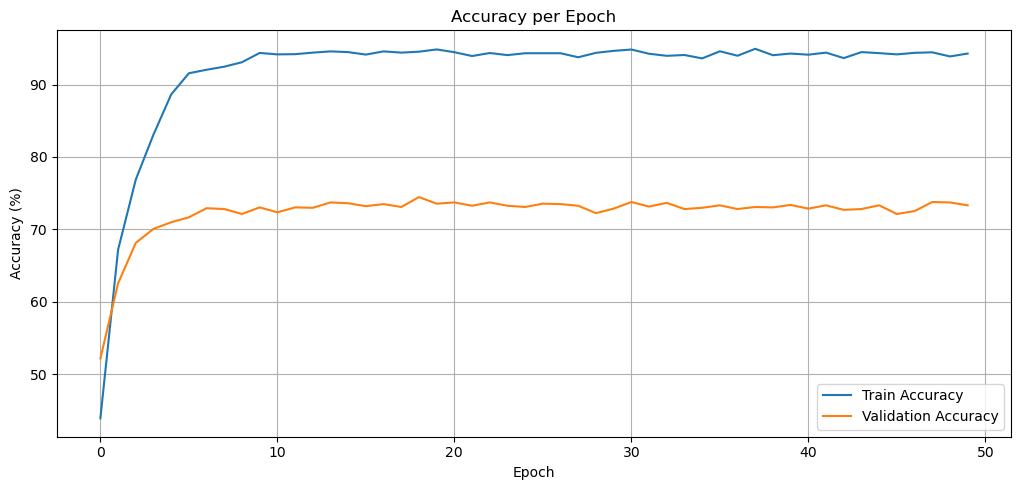

In [13]:
# Plot Accuracies
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(metrics_df['Epoch'], metrics_df['Train Accuracy'], label='Train Accuracy')
plt.plot(metrics_df['Epoch'], metrics_df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists for storing true and predicted labels
true_labels = []
predicted_labels = []

In [18]:
# Define the directory to save/load models
save_dir = r'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\resnet50'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Function to load the latest checkpoint
def load_checkpoint(model, optimizer, scheduler, filename='latest_checkpoint.pth'):
    if os.path.exists(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
        print(f"Resuming from epoch {start_epoch}")
    else:
        print(f"No checkpoint found at '{filename}', starting from scratch")
        start_epoch = 0  # Start from scratch if no checkpoint
    return start_epoch

# Load checkpoint if exists
checkpoint_path = os.path.join(save_dir, 'latest_checkpoint.pth')
start_epoch = load_checkpoint(net, optimizer, scheduler, filename=checkpoint_path)

# Training Loop

accuracy = 0
val_accuracy = 0
running_loss = 0.0
val_running_loss = 0.0
num_batches_train = len(dataloader_train)
num_batches_val = len(dataloader_val)

# Training loop
for i, data in enumerate(dataloader_train, 0):
    input = data['data_sample'].float().to(device)
    input = input.permute(0, 3, 1, 2)
    labels = data['lable'].to(device)
    encoded_labels = F.one_hot(labels.long(), num_classes=7)

    prediction = net(input)
    loss = criterion(prediction, encoded_labels.float())
    running_loss += loss.item()

    predicted_class = torch.argmax(prediction, dim=1)
    accuracy += sum(predicted_class == labels)

avg_train_loss = running_loss / num_batches_train

# Validation loop
for i, data in enumerate(dataloader_val, 0):
    input = data['data_sample'].float().to(device)
    input = input.permute(0, 3, 1, 2)
    labels = data['lable'].to(device)
    encoded_labels = F.one_hot(labels.long(), num_classes=7)

    prediction = net(input)
    val_loss = criterion(prediction, encoded_labels.float())
    val_running_loss += val_loss.item()

    predicted_class = torch.argmax(prediction, dim=1)
    val_accuracy += sum(predicted_class == labels)

    true_labels.extend(labels.cpu().numpy())  
    predicted_labels.extend(predicted_class.cpu().numpy()) 

avg_val_loss = val_running_loss / num_batches_val
# avg_val_loss_list.append(avg_val_loss)

Loading checkpoint 'C:\Users\vindu\Documents\FYP_NEW\ML_model\Skin_Cancer\Saved_models\SkinML\resnet50\latest_checkpoint.pth'


C:\Users\vindu\AppData\Local\Temp\ipykernel_18864\47151957.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Resuming from epoch 50


NameError: name 'epoch' is not defined

Train Accuracy: 95.20%, Validation Accuracy: 73.38%


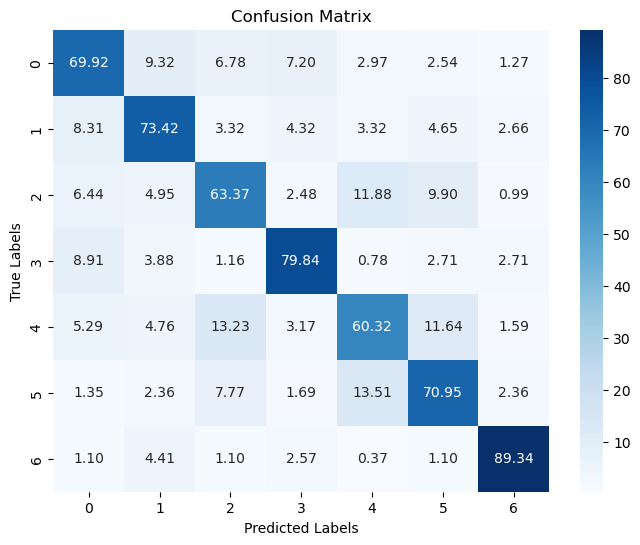

In [22]:
print(f'Train Accuracy: {accuracy/train_dataset.__len__()*100:.2f}%, '
        f'Validation Accuracy: {val_accuracy/val_dataset.__len__()*100:.2f}%')

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Convert to percentage (normalize by row sum)
conf_matrix_percentage = conf_matrix.astype(np.float32)
conf_matrix_percentage /= conf_matrix_percentage.sum(axis=1, keepdims=True)  # Normalize each row
conf_matrix_percentage *= 100  # Convert to percentage

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()